# Bayesian analysis of tests with unknown specificity and sensitivity

**Authors:** Andrew Gelman and Bob Carpenter 

Reparametrization: https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html

Data types: https://mc-stan.org/docs/2_19/reference-manual/univariate-data-types-and-variable-declarations.html

We redo the work developed in the article as exercise using `pystan`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

import pymc3 as pm
import pystan as ps

import pickle

ro = np.random.RandomState(1000)

Prevalence estimates (proportion of some characteristic in a population) is sensible to uncertainty in specificicity and sensitivity of the test. Hierarchical modelling is used with bayesian inference to model it in three different models. 

## Model 1

$$y \sim Bin(n,p),$$
$$p = (1 - \gamma)(1 - \pi) + \delta \pi,$$
$$y_{\gamma} \sim Bin(n_{\gamma}, \gamma),$$
$$y_{\delta} \sim Bin(n_{\delta}, \delta),$$

In [2]:
compiled = True

In [3]:
if compiled: 
    sm = pickle.load(open('pickles/model1.pkl', 'rb'))
else: 
    model = ps.StanModel(file = 'stan_codes/model1.stan')
    with open('pickles/model1.pkl', 'wb') as f:
        pickle.dump(model, f)

## Data

First we simulate the data based on the first model.

In [4]:
n_sample = 100 
n_spec   = 20
n_sens   = 20

spec = 0.9 
sens = 0.9
pi   = 0.01
p    = (1 - spec)*(1 - pi) + sens*pi

y = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [5]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   1,
      "beta_pi":    1,
})

In [6]:
fit = sm.sampling(data=tests_data, iter=2000, chains=2)

In [7]:
print(fit)

Inference for Stan model: anon_model_849577e0f199635bf303c7017a2c9934.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
spec   0.96  1.2e-3   0.03   0.89   0.94   0.97   0.99    1.0    749    1.0
sens   0.76  3.1e-3   0.09   0.55    0.7   0.77   0.83   0.91    957    1.0
pi     0.13  2.3e-3   0.06   0.02   0.09   0.13   0.17   0.27    697    1.0
p      0.13  7.7e-4   0.03   0.07   0.11   0.13   0.15    0.2   1854    1.0
lp__  -56.5    0.05   1.34  -59.9 -57.16 -56.15  -55.5 -54.93    656    1.0

Samples were drawn using NUTS at Sun Jun 20 17:37:14 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


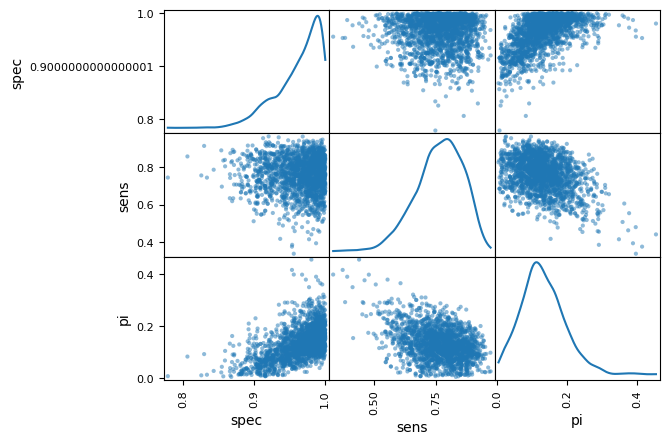

In [8]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

We test some other values. 

In [9]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=2000, chains=2, control=dict(adapt_delta=0.95))
print(fit)

Inference for Stan model: anon_model_849577e0f199635bf303c7017a2c9934.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

       mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
spec   0.91  2.3e-3   0.04    0.84    0.88   0.91   0.93   0.99    290    1.0
sens   0.77  3.6e-3   0.09    0.57    0.72   0.78   0.84   0.91    589    1.0
pi     0.02  3.6e-3   0.05 6.7e-16 1.3e-11 5.1e-7   0.01   0.17    195    1.0
p      0.11  7.6e-4   0.03    0.06    0.09   0.11   0.13   0.17   1515    1.0
lp__ -54.29    0.04   1.04   -57.0  -54.74 -54.01 -53.58 -52.83    731    1.0

Samples were drawn using NUTS at Sun Jun 20 17:37:19 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Model 2

Now we adapt to a hierarchical model

$$
logit(\gamma_j) \sim normal(\mu_{\gamma}, \sigma_{\gamma}) \\
logit(\delta_j) \sim normal(\mu_{\delta}, \sigma_{\delta})
$$

where $j=1,...,J$ are studies for each parameter. 

**Remark:** The reparameterization of `logit_spec` and `logit_sens` with offset and multiplier, we obtain a non-central distribution wahat is computationally better. 

In [10]:
compiled = True

In [11]:
if compiled: 
    sm = pickle.load(open('pickles/model2.pkl', 'rb'))
else: 
    model = ps.StanModel(file = 'stan_codes/model2.stan')
    with open('pickles/model2.pkl', 'wb') as f:
        pickle.dump(model, f)

## Data

First we simulate the data based on the second model.

In [12]:
n_sample = 100

J_spec   = 5
n_spec   = np.array([10,30,15,20,40])
J_sens   = 5
n_sens   = np.array([10,30,15,20,40])

mu_spec = np.array([2.5, 3.5, 2.2, 4.1, 3.2])
mu_sens = np.array([2.5, 3.5, 2.2, 4.1, 3.2])

sigma_spec = np.array([0.5, 0.2, 0.6, 0.1, 0.2])
sigma_sens = np.array([0.5, 0.2, 0.6, 0.1, 0.2])

spec = expit(ro.normal(loc = mu_spec, scale = sigma_spec))
sens = expit(ro.normal(loc = mu_spec, scale = sigma_spec))

pi   = 0.01
p    = (1 - spec[0])*(1 - pi) + sens[0]*pi

y      = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "J_spec": J_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "J_sens": J_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [13]:
tests_data.update({
      "alpha_pi"             : 0.1,
      "beta_pi"              : 1.9,  
      "mean_hyper_mean_spec" : 3,
      "mean_hyper_mean_sens" : 3, 
      "sd_hyper_mean_spec"   : 2,
      "sd_hyper_mean_sens"   : 2,
      "sd_hyper_sd_spec"     : 1,
      "sd_hyper_sd_sens"     : 1,
})

In [14]:
fit = sm.sampling(data=tests_data, iter=3000, chains=4, control=dict(adapt_delta=0.95))

In [15]:
print(fit)

Inference for Stan model: anon_model_06baf3a880a9841aab05eae7b6458784.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                  mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi              3.0e-3  1.0e-4 8.0e-3 2.7e-14 5.5e-8 3.0e-5 1.4e-3   0.03   6211    1.0
mean_logit_spec   3.17    0.02   0.77    1.73   2.67   3.13   3.62   4.82   2268    1.0
mean_logit_sens   3.71    0.02   0.89    2.12   3.12   3.64   4.24   5.65   3032    1.0
sd_logit_spec     1.42    0.01   0.53    0.47   1.07   1.37   1.72    2.6   2644    1.0
sd_logit_sens     1.42    0.01   0.62    0.22   0.99   1.39   1.81   2.74   2321    1.0
logit_spec[1]     3.65  7.5e-3   0.62    2.63   3.22   3.58    4.0   5.03   6725    1.0
logit_spec[2]     2.51  7.4e-3   0.63    1.38   2.08   2.47    2.9   3.82   7175    1.0
logit_spec[3]      1.2    0.01   0.64    0.05   0.75   1.16    1.6   2.62   3230    1.0
logit_spec[4]     4

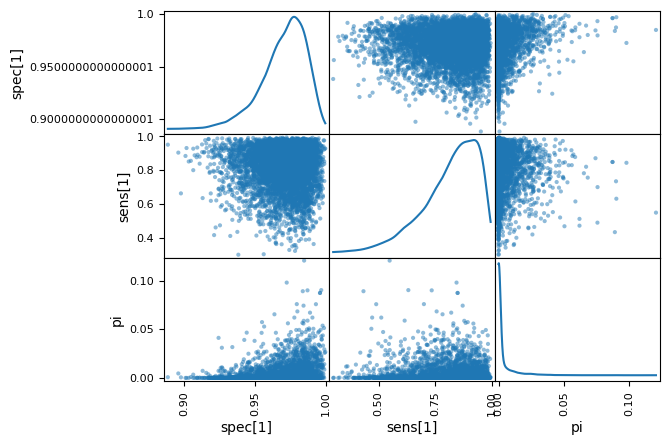

In [16]:
df_trace = pd.DataFrame(fit.extract(['spec[1]', 'sens[1]', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

In [17]:
tests_data.update({
      "alpha_pi"             : 0.001,
      "beta_pi"              : 0.019,  
      "mean_hyper_mean_spec" : 0.5,
      "mean_hyper_mean_sens" : 0.5, 
      "sd_hyper_mean_spec"   : 0.5,
      "sd_hyper_mean_sens"   : 0.5,
      "sd_hyper_sd_spec"     : 0.5,
      "sd_hyper_sd_sens"     : 0.5,
})

fit = sm.sampling(data=tests_data, iter=2000, chains=4, control=dict(adapt_delta=0.95, max_treedepth=12))
print(fit)

Inference for Stan model: anon_model_06baf3a880a9841aab05eae7b6458784.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                  mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
pi              7.5e-4  6.6e-5 4.0e-3 2.2e-16 3.6e-13 1.6e-9 4.8e-6 9.2e-3   3623    1.0
mean_logit_spec   1.54    0.01   0.43    0.69    1.24   1.56   1.84   2.36   1685    1.0
mean_logit_sens   1.61    0.01   0.46    0.68    1.29   1.63   1.95   2.47   1745    1.0
sd_logit_spec     1.13  7.2e-3   0.33    0.52     0.9   1.11   1.34    1.8   2039    1.0
sd_logit_sens     1.08  9.9e-3   0.38    0.31    0.82   1.07   1.33   1.83   1482    1.0
logit_spec[1]     3.25  7.6e-3   0.48    2.39    2.92   3.22   3.55    4.3   4033    1.0
logit_spec[2]     2.13  7.2e-3   0.52    1.21    1.77   2.09   2.46   3.21   5143    1.0
logit_spec[3]     0.96  8.4e-3   0.54   -0.05    0.59   0.95    1.3   2.07   4164    1.0
logit_spec